<a href="https://colab.research.google.com/github/sabeesh90/Advanced_Neural_Network_MosaicML/blob/main/Mosaic_ML_MNIST_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mosaic Ml

In [ ]:
# !pip install mosaicml
# !pip uninstall pillow
!pip install pillow-simd

In [ ]:
!pip install pillow


  Using cached Pillow-8.4.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# !pip install torchcontrib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab Notebooks/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


In [ ]:

# from torchcontrib.optim import SWA

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from torchsummary import summary
# from torchcontrib.optim import SWA
import composer
from composer import DataloaderSpec
from composer import Trainer
from composer.algorithms import LabelSmoothing, CutOut, BlurPool, scale_schedule, SWA,SAM, MixUp, SqueezeExcite,ScaleSchedule 

#### BASEMODEL  - 7K PARAMETERS

In [ ]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
    #####################################################################################################
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(8),
        ) # input size = 28 output_size = 26, in channels  = 1 out channels = 16

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),            
        ) # input_size = 26 , output_size = 24, 16 to 32 channels

        self.dropout1  = nn.Sequential(nn.Dropout(0.05))
    #####################################################################################################

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # input size  = 24, output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # input sizez = 24, output_size = 12
    #####################################################################################################

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            # nn.Dropout(dropout_value)
        ) # input size = 12, output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            # nn.Dropout(dropout_value)
        ) # input size = 10, output_size = 8
        self.dropout2  = nn.Sequential(nn.Dropout(0.17))
    #####################################################################################################

        # adding a 1x1 kernel  block here to reduce paramters
        self.convblock5a = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
        ) # input size  = 8, output_size = 8
        self.pool2 = nn.MaxPool2d(2, 2) # input sizez = 8, output_size = 4
    #####################################################################################################

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            # nn.Dropout(dropout_value)
        ) # input size  = 4,  output_size = 4
        self.dropout3  = nn.Sequential(nn.Dropout(0.17))
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            # nn.Dropout(0.03)
        ) # input size  = 4, output_size = 4
    #####################################################################################################        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1 channels  = 16

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

    def forward(self, x):
        # first conv block - teacher
        x = self.convblock1(x)
        x = self.convblock2(x)
        x  = self.dropout1(x)

        # transition block
        x = self.convblock3(x)
        x = self.pool1(x)

        # second conv block
        x = self.convblock4(x)
        x = self.convblock5(x)
        x  = self.dropout2(x)

        # secocnd transition block
        x = self.convblock5a(x)
        x = self.pool2(x)        

        # third conv block
        x = self.convblock6(x)
        x = self.dropout3(x)
        x = self.convblock7(x)

        # global average pooling layer
        x = self.gap(x) 

        # classification
        
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

#### SMALLER MODEL - 5K

In [ ]:
class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()
    #####################################################################################################
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(8),
        ) # input size = 28 output_size = 26, in channels  = 1 out channels = 16

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),            
        ) # input_size = 26 , output_size = 24, 16 to 32 channels

        self.dropout1  = nn.Sequential(nn.Dropout(0.05))
    #####################################################################################################

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # input size  = 24, output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # input sizez = 24, output_size = 12
    #####################################################################################################

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            # nn.Dropout(dropout_value)
        ) # input size = 12, output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            # nn.Dropout(dropout_value)
        ) # input size = 10, output_size = 8
        self.dropout2  = nn.Sequential(nn.Dropout(0.17))
    #####################################################################################################

        # adding a 1x1 kernel  block here to reduce paramters
        self.convblock5a = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
        ) # input size  = 8, output_size = 8
        self.pool2 = nn.MaxPool2d(2, 2) # input sizez = 8, output_size = 4
    #####################################################################################################

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            # nn.Dropout(dropout_value)
        ) # input size  = 4,  output_size = 4
        self.dropout3  = nn.Sequential(nn.Dropout(0.17))
        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),            
        #     nn.BatchNorm2d(15),
        #     # nn.Dropout(0.03)
        # ) # input size  = 4, output_size = 4
    #####################################################################################################        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1 channels  = 16

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

    def forward(self, x):
        # first conv block-assistant
        # x = x.to("cuda")
        x = self.convblock1(x)
        x = self.convblock2(x)
        x  = self.dropout1(x)

        # transition block
        x = self.convblock3(x)
        x = self.pool1(x)

        # second conv block
        x = self.convblock4(x)
        x = self.convblock5(x)
        x  = self.dropout2(x)

        # secocnd transition block
        x = self.convblock5a(x)
        x = self.pool2(x)        

        # third conv block
        x = self.convblock6(x)
        x = self.dropout3(x)
        # x = self.convblock7(x)

        # global average pooling layer
        x = self.gap(x) 

        # classification        
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

#### SMALLEST MODEL

In [ ]:
class SNet(nn.Module):
    def __init__(self):
        super(SNet, self).__init__()
    #####################################################################################################
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(8),
        ) # input size = 28 output_size = 26, in channels  = 1 out channels = 16

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            # DEPTH WISE SEPERABLE COVOLUTION
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), groups = 8, padding=0, bias=False),
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(1, 1), groups = 1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),            
        ) # input_size = 26 , output_size = 24, 16 to 32 channels

        self.dropout1  = nn.Sequential(nn.Dropout(0.05))
    #####################################################################################################

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # input size  = 24, output_size = 24 3 receptive field  - does not change
        self.pool1 = nn.MaxPool2d(2, 2) # input sizez = 24, output_size = 12
    #####################################################################################################

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            # DEPTH WISE SEPARABLE CONVOLUTIONS
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), groups = 8, padding=0, bias=False),
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            # nn.Dropout(dropout_value)
        ) # input size = 12, output_size = 10
        self.convblock5 = nn.Sequential(
            # DEPTH WISE SEPARABLE CONVOLUTIONS
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3),groups = 12, padding=0, bias=False),
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            # nn.Dropout(dropout_value)
        ) # input size = 10, output_size = 8
        self.dropout2  = nn.Sequential(nn.Dropout(0.17))
    #####################################################################################################

        # adding a 1x1 kernel  block here to reduce paramters
        self.convblock5a = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
        ) # input size  = 8, output_size = 8
        self.pool2 = nn.MaxPool2d(2, 2) # input sizez = 8, output_size = 4
    #####################################################################################################

        self.convblock6 = nn.Sequential(
            # DEPTH WISE SEPARABLE CONVOLUTIONS
            nn.Conv2d(in_channels=12, out_channels=12,groups = 12, kernel_size=(3, 3), padding=1, bias=False),
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            # nn.Dropout(dropout_value)
        ) # input size  = 4,  output_size = 4
        self.dropout3  = nn.Sequential(nn.Dropout(0.17))
    #####################################################################################################        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1 channels  = 16
        self.flat = nn.Flatten()
        # self.convblock8 = nn.Sequential(
            # nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        # ) 
        self.linear = nn.Linear(15,10)

    def forward(self, x):
        # first conv block - student
        # x = x.to("cuda")
        x = self.convblock1(x)
        x = self.convblock2(x)
        x  = self.dropout1(x)

        # transition block
        x = self.convblock3(x)
        x = self.pool1(x)

        # second conv block
        x = self.convblock4(x)
        x = self.convblock5(x)
        x  = self.dropout2(x)

        # secocnd transition block
        x = self.convblock5a(x)
        x = self.pool2(x)        

        # third conv block
        x = self.convblock6(x)
        x = self.dropout3(x)
        # x = self.convblock7(x)

        # global average pooling layer
        x = self.gap(x) 
        x = self.flat(x)
        # classification        
        # x = self.convblock8(x)
        x = self.linear(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

#### SMALLEST MODEL 2

In [ ]:
class SimpleModel(composer.models.MosaicClassifier):
    def __init__(self, num_classes: int):
        module = nn.Sequential(
    ################################## 1 ST CONVOLUTIONAL BLOCK #####################################  
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(8),                                                                                #26x26 /8 

            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), groups = 8, padding=0, bias=False),  #24x24/8
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(1, 1), groups = 1, padding=0, bias=False), #24x24/12
            nn.ReLU(),
            nn.BatchNorm2d(12), 

            nn.Dropout(0.05),
    ################################### TRANSITION BLOCK #######################################
            nn.Conv2d(in_channels=12, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),             #24x24/8
            nn.MaxPool2d(2, 2),                                                                               #12x12/8
    ################################## 2 ND CONVOLUTIONAL BLOCK #####################################            

            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), groups = 8, padding=0, bias=False),  #10x10/8
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),             #10x10/12
            nn.ReLU(),            
            nn.BatchNorm2d(12),

            # DEPTH WISE SEPARABLE CONVOLUTIONS
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3),groups = 12, padding=0, bias=False), #8x8/12
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),             #8x8/16
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            
            nn.Dropout(0.17),
    ################################### TRANSITION BLOCK #######################################
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),            #8x8/12
            nn.MaxPool2d(2, 2),                                                                               #4x4/12
    ################################## 3 RD CONVOLUTIONAL BLOCK ##################################### 
            nn.Conv2d(in_channels=12, out_channels=12,groups = 12, kernel_size=(3, 3), padding=1, bias=False),#4x4/12
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=(1, 1), padding=0, bias=False),            #4x4/15
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            
            nn.Dropout(0.17),
    ################################### OUTPUT BLOCK ######################################        
            nn.AvgPool2d(kernel_size=4),                                                                      #1x1/15
            # nn.Linear(1,10),
            nn.Flatten(),
            # nn.Conv2d(in_channels=15, out_channels=num_classes, kernel_size=(1, 1), padding=0, bias=False),
            nn.Linear(15,10)
        )
        self.num_classes = num_classes
        super().__init__(module=module)

In [ ]:
m = SimpleModel(num_classes= 10)

#### MODEL AND DATASET LOADING


In [ ]:
train_dataloader_spec = DataloaderSpec(
    dataset=datasets.MNIST('/datasets/', train=True, transform=transforms.ToTensor(), download=True),
    drop_last=False,
    shuffle=True,
)

eval_dataloader_spec = DataloaderSpec(
    dataset=datasets.MNIST('/datasets/', train=False, transform=transforms.ToTensor()),
    drop_last=False,
    shuffle=False,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /datasets/MNIST/raw/train-images-idx3-ubyte.gz to /datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /datasets/MNIST/raw



In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    algorithms=[
        # CutOut(n_holes=1, length=10),
        # LabelSmoothing(alpha=0.1),
        BlurPool(replace_convs= True, replace_maxpools = True, blur_first = False),
        SWA(swa_start=0.75, swa_lr=None),
        SqueezeExcite(latent_channels=2, min_channels=5)

    ]
)


/usr/local/lib/python3.7/dist-packages/composer/trainer/ddp.py:137: UserWarning: NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. If this is unexpected, make sure you are running your training script with the composer executable.
  warnings.warn("NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. "
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
Scheduler is stepping every epoch, but provi

In [ ]:
trainer.fit()

/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: WORLD_SIZE env var not set and process group not initialized; returning 1 for world size.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not 

#### CUTOUT

In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    algorithms=[
        CutOut(n_holes=1, length=10),
        # LabelSmoothing(alpha=0.1),
    ]
)


/usr/local/lib/python3.7/dist-packages/composer/trainer/ddp.py:137: UserWarning: NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. If this is unexpected, make sure you are running your training script with the composer executable.
  warnings.warn("NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. "
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
Scheduler is stepping every epoch, but provided timestring 5ba had batches. Ignoring the batches term.


In [ ]:
trainer.fit()

/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: WORLD_SIZE env var not set and process group not initialized; returning 1 for world size.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not 

#### BLURPOOL

In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    algorithms=[
        # CutOut(n_holes=1, length=10),
        # LabelSmoothing(alpha=0.1),
        BlurPool(replace_convs= True, replace_maxpools = True, blur_first = False)
    ]
)


/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
Scheduler is stepping every epoch, but provided timestring 5ba had batches. Ignoring the batches term.


In [ ]:
trainer.fit()

/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: WORLD_SIZE env var not set and process group not initialized; returning 1 for world size.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not 

#### LABEL SMOOTHING

In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    checkpoint_interval_unit="ep",
    checkpoint_folder="label_smoothing_checkpoints",
    checkpoint_interval=1,
    # device =  'DeviceGPU',
    # device ='cuda',
    algorithms=[
        # CutOut(n_holes=1, length=10),
        LabelSmoothing(alpha=0.1),
        # BlurPool(replace_convs= True, replace_maxpools = True, blur_first = False)
    ],
)


/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"


In [ ]:
trainer.fit

In [ ]:
trainer.fit()

/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: WORLD_SIZE env var not set and process group not initialized; returning 1 for world size.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not 

<All keys matched successfully>

In [ ]:
m.eval()

SimpleModel(
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (val_loss): CrossEntropyLoss()
  (module): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), groups=8, bias=False)
    (4): Conv2d(8, 12, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.05, inplace=False)
    (8): Conv2d(12, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), groups=8, bias=False)
    (11): Conv2d(8, 12, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (12): ReLU()
    (13): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

#### MIXUP

In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    checkpoint_interval_unit="ep",
    checkpoint_folder="mixup_checkpoints",
    checkpoint_interval=1,
    # device =  'DeviceGPU',
    # device ='cuda',
    algorithms=[
        # CutOut(n_holes=1, length=10),
        MixUp(0.5),
        # BlurPool(replace_convs= True, replace_maxpools = True, blur_first = False)
    ],
)


/usr/local/lib/python3.7/dist-packages/composer/trainer/ddp.py:137: UserWarning: NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. If this is unexpected, make sure you are running your training script with the composer executable.
  warnings.warn("NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. "
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
Scheduler is stepping every epoch, but provided timestring 5ba had batches. Ignoring the batches term.


In [ ]:
trainer.fit()

/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: WORLD_SIZE env var not set and process group not initialized; returning 1 for world size.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not 

#### SHARPNESS AWARENESS MINIMIZATION

In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    checkpoint_interval_unit="ep",
    checkpoint_folder="sam_checkpoints",
    checkpoint_interval=1,
    # device =  'DeviceGPU',
    # device ='cuda',
    algorithms=[
        SAM()
    ],
)


/usr/local/lib/python3.7/dist-packages/composer/trainer/ddp.py:137: UserWarning: NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. If this is unexpected, make sure you are running your training script with the composer executable.
  warnings.warn("NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. "
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
Scheduler is stepping every epoch, but provided timestring 5ba had batches. Ignoring the batches term.


In [ ]:
trainer.fit()

/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: WORLD_SIZE env var not set and process group not initialized; returning 1 for world size.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not 

#### STOCHASTIC WEIGHT AVERAGING

In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    checkpoint_interval_unit="ep",
    checkpoint_folder="swa_checkpoints",
    checkpoint_interval=1,
    # device =  'DeviceGPU',
    # device ='cuda',
    algorithms=[
        SWA(swa_start=0.75, swa_lr=None)
    ],
)

/usr/local/lib/python3.7/dist-packages/composer/trainer/ddp.py:137: UserWarning: NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. If this is unexpected, make sure you are running your training script with the composer executable.
  warnings.warn("NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. "
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
Scheduler is stepping every epoch, but provided timestring 5ba had batches. Ignoring the batches term.


In [ ]:
trainer.fit()

/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: WORLD_SIZE env var not set and process group not initialized; returning 1 for world size.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not 

#### SCALE AND SCHEDULE

In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    checkpoint_interval_unit="ep",
    checkpoint_folder="squeeze_checkpoints",
    checkpoint_interval=1,
    # device =  'DeviceGPU',
    # device ='cuda',
    algorithms=[
        ScaleSchedule()
    ],
)

In [ ]:
trainer.fit()

#### SQUEEZE AND EXCITE

In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    checkpoint_interval=1,
    # device =  'DeviceGPU',
    # device ='cuda',
    algorithms=[
        SqueezeExcite(latent_channels=2, min_channels=5)
    ],
)

/usr/local/lib/python3.7/dist-packages/composer/trainer/ddp.py:137: UserWarning: NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. If this is unexpected, make sure you are running your training script with the composer executable.
  warnings.warn("NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. "
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
Scheduler is stepping every epoch, but provi

In [ ]:
trainer.fit()

/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: WORLD_SIZE env var not set and process group not initialized; returning 1 for world size.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not 

# <center>  🦩 NORMAL TRAINING OF MODELS 😛</center>




#### TRAINING THE BASE MODEL - 7K PARAMETERS

In [ ]:
epochs = 35
optimizer = optim.Adam(model.parameters(), lr = 0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
path = './quantization/pytorch_model/normal_pytorch.pth'

execute_model(model, save_best_model=True)

EPOCH: 0


Loss=0.15339292585849762 Batch_id=468 Accuracy=94.43: 100%|██████████| 469/469 [00:06<00:00, 69.84it/s]



Test set: Average loss: 0.0572, Accuracy: 9827/10000 (98.27%)

98.27 98.27
Saving model here
EPOCH: 1


Loss=0.06952603161334991 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:06<00:00, 71.22it/s]



Test set: Average loss: 0.0386, Accuracy: 9873/10000 (98.73%)

98.73 98.73
Saving model here
EPOCH: 2


Loss=0.016729645431041718 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:06<00:00, 72.09it/s]



Test set: Average loss: 0.0561, Accuracy: 9825/10000 (98.25%)

98.73 98.25
EPOCH: 3


Loss=0.0661846324801445 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:06<00:00, 70.92it/s]



Test set: Average loss: 0.0362, Accuracy: 9881/10000 (98.81%)

98.81 98.81
Saving model here
EPOCH: 4


Loss=0.07204645127058029 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:06<00:00, 71.03it/s]



Test set: Average loss: 0.0315, Accuracy: 9903/10000 (99.03%)

99.03 99.03
Saving model here
EPOCH: 5


Loss=0.015035615302622318 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:06<00:00, 72.17it/s]



Test set: Average loss: 0.0231, Accuracy: 9921/10000 (99.21%)

99.21 99.21
Saving model here
EPOCH: 6


Loss=0.010473202913999557 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:06<00:00, 67.50it/s]



Test set: Average loss: 0.0221, Accuracy: 9923/10000 (99.23%)

99.23 99.23
Saving model here
EPOCH: 7


Loss=0.001946059986948967 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:06<00:00, 70.48it/s]



Test set: Average loss: 0.0215, Accuracy: 9925/10000 (99.25%)

99.25 99.25
Saving model here
EPOCH: 8


Loss=0.022356733679771423 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:06<00:00, 68.77it/s]



Test set: Average loss: 0.0215, Accuracy: 9927/10000 (99.27%)

99.27 99.27
Saving model here
EPOCH: 9


Loss=0.018330330029129982 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:06<00:00, 69.27it/s]



Test set: Average loss: 0.0212, Accuracy: 9927/10000 (99.27%)

99.27 99.27
Saving model here
EPOCH: 10


Loss=0.004080866929143667 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:06<00:00, 70.29it/s]



Test set: Average loss: 0.0209, Accuracy: 9930/10000 (99.30%)

99.3 99.3
Saving model here
EPOCH: 11


Loss=0.08688917011022568 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:06<00:00, 70.28it/s]



Test set: Average loss: 0.0211, Accuracy: 9929/10000 (99.29%)

99.3 99.29
EPOCH: 12


Loss=0.009718340821564198 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:06<00:00, 70.12it/s]



Test set: Average loss: 0.0207, Accuracy: 9930/10000 (99.30%)

99.3 99.3
Saving model here
EPOCH: 13


Loss=0.007006799336522818 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:06<00:00, 68.19it/s]



Test set: Average loss: 0.0209, Accuracy: 9928/10000 (99.28%)

99.3 99.28
EPOCH: 14


Loss=0.06782213598489761 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:06<00:00, 68.79it/s]



Test set: Average loss: 0.0201, Accuracy: 9932/10000 (99.32%)

99.32 99.32
Saving model here
EPOCH: 15


Loss=0.0012393639190122485 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:06<00:00, 69.05it/s]



Test set: Average loss: 0.0200, Accuracy: 9932/10000 (99.32%)

99.32 99.32
Saving model here
EPOCH: 16


Loss=0.01360094454139471 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:06<00:00, 68.02it/s]



Test set: Average loss: 0.0204, Accuracy: 9928/10000 (99.28%)

99.32 99.28
EPOCH: 17


Loss=0.06405089050531387 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:06<00:00, 70.58it/s]



Test set: Average loss: 0.0202, Accuracy: 9931/10000 (99.31%)

99.32 99.31
EPOCH: 18


Loss=0.023392995819449425 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:06<00:00, 67.15it/s]



Test set: Average loss: 0.0200, Accuracy: 9932/10000 (99.32%)

99.32 99.32
Saving model here
EPOCH: 19


Loss=0.050768379122018814 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:06<00:00, 69.67it/s]



Test set: Average loss: 0.0202, Accuracy: 9932/10000 (99.32%)

99.32 99.32
Saving model here
EPOCH: 20


Loss=0.007128644734621048 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:06<00:00, 69.03it/s]



Test set: Average loss: 0.0197, Accuracy: 9934/10000 (99.34%)

99.34 99.34
Saving model here
EPOCH: 21


Loss=0.016641510650515556 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:06<00:00, 68.30it/s]



Test set: Average loss: 0.0207, Accuracy: 9929/10000 (99.29%)

99.34 99.29
EPOCH: 22


Loss=0.011976771987974644 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:06<00:00, 68.26it/s]



Test set: Average loss: 0.0203, Accuracy: 9931/10000 (99.31%)

99.34 99.31
EPOCH: 23


Loss=0.03262348100543022 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:06<00:00, 69.71it/s]



Test set: Average loss: 0.0202, Accuracy: 9929/10000 (99.29%)

99.34 99.29
EPOCH: 24


Loss=0.006297822576016188 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:06<00:00, 68.38it/s]



Test set: Average loss: 0.0203, Accuracy: 9930/10000 (99.30%)

99.34 99.3
EPOCH: 25


Loss=0.024611635133624077 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:06<00:00, 69.17it/s]



Test set: Average loss: 0.0203, Accuracy: 9929/10000 (99.29%)

99.34 99.29
EPOCH: 26


Loss=0.007088321726769209 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:06<00:00, 69.26it/s]



Test set: Average loss: 0.0199, Accuracy: 9930/10000 (99.30%)

99.34 99.3
EPOCH: 27


Loss=0.004095739219337702 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:06<00:00, 69.32it/s]



Test set: Average loss: 0.0204, Accuracy: 9932/10000 (99.32%)

99.34 99.32
EPOCH: 28


Loss=0.021514199674129486 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:07<00:00, 66.33it/s]



Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

99.34 99.32
EPOCH: 29


Loss=0.04046601802110672 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:06<00:00, 69.82it/s]



Test set: Average loss: 0.0200, Accuracy: 9929/10000 (99.29%)

99.34 99.29
EPOCH: 30


Loss=0.002756377449259162 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:06<00:00, 67.29it/s]



Test set: Average loss: 0.0203, Accuracy: 9929/10000 (99.29%)

99.34 99.29
EPOCH: 31


Loss=0.008283277042210102 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:06<00:00, 70.71it/s]



Test set: Average loss: 0.0199, Accuracy: 9930/10000 (99.30%)

99.34 99.3
EPOCH: 32


Loss=0.06211312115192413 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:06<00:00, 69.46it/s]



Test set: Average loss: 0.0200, Accuracy: 9931/10000 (99.31%)

99.34 99.31
EPOCH: 33


Loss=0.0014021983370184898 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:06<00:00, 68.11it/s]



Test set: Average loss: 0.0202, Accuracy: 9931/10000 (99.31%)

99.34 99.31
EPOCH: 34


Loss=0.021794309839606285 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:06<00:00, 70.09it/s]



Test set: Average loss: 0.0203, Accuracy: 9931/10000 (99.31%)

99.34 99.31


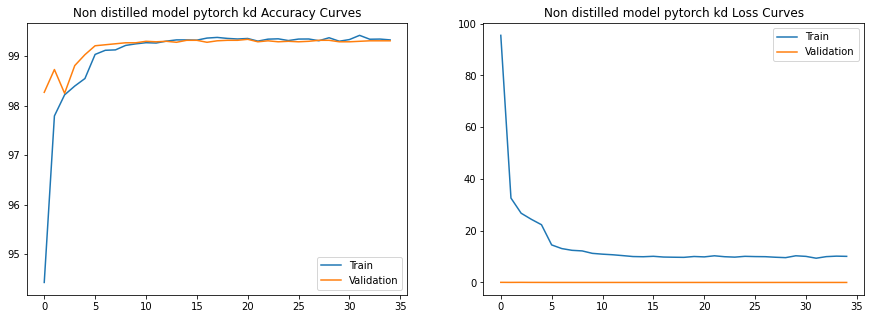

In [ ]:
plot_curves('Non distilled model pytorch kd',log = False)

#### TRAINING THE SMALLER MODEL 5K PARAMETERS

In [ ]:
epochs = 35
optimizer = optim.Adam(cmodel.parameters(), lr = 0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
path = './quantization/pytorch_model/small_pytorch.pth'

execute_model(cmodel, save_best_model=True)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.09446567296981812 Batch_id=468 Accuracy=92.84: 100%|██████████| 469/469 [00:05<00:00, 80.10it/s]



Test set: Average loss: 0.0808, Accuracy: 9747/10000 (97.47%)

97.47 97.47


  0%|          | 0/469 [00:00<?, ?it/s]

Saving model here
EPOCH: 1


Loss=0.023354997858405113 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:05<00:00, 79.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0597, Accuracy: 9799/10000 (97.99%)

97.99 97.99
Saving model here
EPOCH: 2


Loss=0.042415399104356766 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:06<00:00, 77.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9853/10000 (98.53%)

98.53 98.53
Saving model here
EPOCH: 3


Loss=0.06900618225336075 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:05<00:00, 78.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0438, Accuracy: 9867/10000 (98.67%)

98.67 98.67
Saving model here
EPOCH: 4


Loss=0.05066603049635887 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:05<00:00, 78.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9876/10000 (98.76%)

98.76 98.76
Saving model here
EPOCH: 5


Loss=0.004923364147543907 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:05<00:00, 80.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9923/10000 (99.23%)

99.23 99.23
Saving model here
EPOCH: 6


Loss=0.03578788787126541 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:05<00:00, 79.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9922/10000 (99.22%)

99.23 99.22
EPOCH: 7


Loss=0.01682802103459835 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:05<00:00, 79.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9922/10000 (99.22%)

99.23 99.22
EPOCH: 8


Loss=0.03526757284998894 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:05<00:00, 78.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9917/10000 (99.17%)

99.23 99.17
EPOCH: 9


Loss=0.015652265399694443 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:06<00:00, 77.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9918/10000 (99.18%)

99.23 99.18
EPOCH: 10


Loss=0.04183236137032509 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:06<00:00, 77.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9920/10000 (99.20%)

99.23 99.2
EPOCH: 11


Loss=0.013374987989664078 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:06<00:00, 77.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9918/10000 (99.18%)

99.23 99.18
EPOCH: 12


Loss=0.03064422495663166 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:06<00:00, 77.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9919/10000 (99.19%)

99.23 99.19
EPOCH: 13


Loss=0.001597509253770113 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:06<00:00, 78.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9923/10000 (99.23%)

99.23 99.23
Saving model here
EPOCH: 14


Loss=0.03041328489780426 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:05<00:00, 78.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9924/10000 (99.24%)

99.24 99.24
Saving model here
EPOCH: 15


Loss=0.008930002339184284 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:05<00:00, 78.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9921/10000 (99.21%)

99.24 99.21
EPOCH: 16


Loss=0.07730167359113693 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:06<00:00, 78.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9924/10000 (99.24%)

99.24 99.24
Saving model here
EPOCH: 17


Loss=0.004209389444440603 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:05<00:00, 78.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9922/10000 (99.22%)

99.24 99.22
EPOCH: 18


Loss=0.009869230911135674 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:05<00:00, 78.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9921/10000 (99.21%)

99.24 99.21
EPOCH: 19


Loss=0.004959889221936464 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:05<00:00, 79.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9924/10000 (99.24%)

99.24 99.24
Saving model here
EPOCH: 20


Loss=0.02059474028646946 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:06<00:00, 77.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9922/10000 (99.22%)

99.24 99.22
EPOCH: 21


Loss=0.012588709592819214 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:05<00:00, 78.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9927/10000 (99.27%)

99.27 99.27
Saving model here
EPOCH: 22


Loss=0.026391394436359406 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:06<00:00, 77.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9921/10000 (99.21%)

99.27 99.21
EPOCH: 23


Loss=0.02151159942150116 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:05<00:00, 78.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9927/10000 (99.27%)

99.27 99.27
Saving model here
EPOCH: 24


Loss=0.02412646822631359 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:05<00:00, 78.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9927/10000 (99.27%)

99.27 99.27
Saving model here
EPOCH: 25


Loss=0.03053220361471176 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:06<00:00, 77.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9925/10000 (99.25%)

99.27 99.25
EPOCH: 26


Loss=0.012529429979622364 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:05<00:00, 78.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9923/10000 (99.23%)

99.27 99.23
EPOCH: 27


Loss=0.026365546509623528 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:06<00:00, 77.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9922/10000 (99.22%)

99.27 99.22
EPOCH: 28


Loss=0.005559570621699095 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:06<00:00, 77.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9921/10000 (99.21%)

99.27 99.21
EPOCH: 29


Loss=0.04071180894970894 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:05<00:00, 78.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9922/10000 (99.22%)

99.27 99.22
EPOCH: 30


Loss=0.056327540427446365 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:06<00:00, 76.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9923/10000 (99.23%)

99.27 99.23
EPOCH: 31


Loss=0.004104877822101116 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:06<00:00, 76.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9925/10000 (99.25%)

99.27 99.25
EPOCH: 32


Loss=0.019914666190743446 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:06<00:00, 77.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9921/10000 (99.21%)

99.27 99.21
EPOCH: 33


Loss=0.006134682800620794 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:06<00:00, 77.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9925/10000 (99.25%)

99.27 99.25
EPOCH: 34


Loss=0.005547244567424059 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:06<00:00, 77.73it/s]



Test set: Average loss: 0.0226, Accuracy: 9921/10000 (99.21%)

99.27 99.21


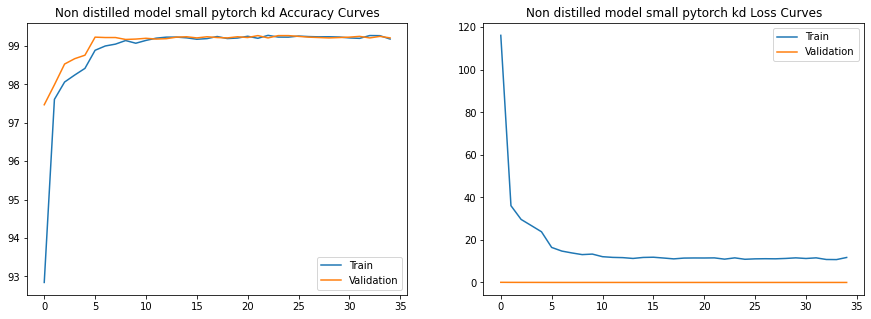

In [ ]:
plot_curves('Non distilled model small pytorch kd',log = False)

#### SUMMARY OF THE MODELS

In [ ]:
summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 12, 24, 24]             864
              ReLU-5           [-1, 12, 24, 24]               0
       BatchNorm2d-6           [-1, 12, 24, 24]              24
           Dropout-7           [-1, 12, 24, 24]               0
            Conv2d-8            [-1, 8, 24, 24]              96
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]             864
             ReLU-11           [-1, 12, 10, 10]               0
      BatchNorm2d-12           [-1, 12, 10, 10]              24
           Conv2d-13             [-1, 16, 8, 8]           1,728
             ReLU-14             [-1, 1

In [ ]:
summary(cmodel, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 12, 24, 24]             864
              ReLU-5           [-1, 12, 24, 24]               0
       BatchNorm2d-6           [-1, 12, 24, 24]              24
           Dropout-7           [-1, 12, 24, 24]               0
            Conv2d-8            [-1, 8, 24, 24]              96
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]             864
             ReLU-11           [-1, 12, 10, 10]               0
      BatchNorm2d-12           [-1, 12, 10, 10]              24
           Conv2d-13             [-1, 16, 8, 8]           1,728
             ReLU-14             [-1, 1

In [ ]:
smodel = SNet().to("cuda")
summary(smodel, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4            [-1, 8, 24, 24]              72
            Conv2d-5           [-1, 12, 24, 24]              96
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]              96
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11            [-1, 8, 10, 10]              72
           Conv2d-12           [-1, 12, 10, 10]              96
             ReLU-13           [-1, 12, 10, 10]               0
      BatchNorm2d-14           [-1, 12,

#### TRAINING THE SMALLEST MODEL


In [ ]:
epochs = 45
optimizer = optim.Adam(smodel.parameters(), lr = 0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
path = './quantization/pytorch_model/smallest_pytorch.pth'

execute_model(smodel, save_best_model=True)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.15798884630203247 Batch_id=468 Accuracy=87.20: 100%|██████████| 469/469 [00:06<00:00, 72.15it/s]



Test set: Average loss: 0.1306, Accuracy: 9607/10000 (96.07%)

96.07 96.07


  0%|          | 0/469 [00:00<?, ?it/s]

Saving model here
EPOCH: 1


Loss=0.09820634126663208 Batch_id=468 Accuracy=95.73: 100%|██████████| 469/469 [00:06<00:00, 73.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0822, Accuracy: 9754/10000 (97.54%)

97.54 97.54
Saving model here
EPOCH: 2


Loss=0.07025573402643204 Batch_id=468 Accuracy=96.48: 100%|██████████| 469/469 [00:06<00:00, 73.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0707, Accuracy: 9789/10000 (97.89%)

97.89 97.89
Saving model here
EPOCH: 3


Loss=0.027657246217131615 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:06<00:00, 73.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0937, Accuracy: 9715/10000 (97.15%)

97.89 97.15
EPOCH: 4


Loss=0.15030448138713837 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:06<00:00, 72.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1621, Accuracy: 9501/10000 (95.01%)

97.89 95.01
EPOCH: 5


Loss=0.018971065059304237 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:06<00:00, 71.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0563, Accuracy: 9827/10000 (98.27%)

98.27 98.27
Saving model here
EPOCH: 6


Loss=0.1197003424167633 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:06<00:00, 72.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0568, Accuracy: 9815/10000 (98.15%)

98.27 98.15
EPOCH: 7


Loss=0.1378924399614334 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:06<00:00, 72.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0537, Accuracy: 9824/10000 (98.24%)

98.27 98.24
EPOCH: 8


Loss=0.022824766114354134 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:06<00:00, 73.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9833/10000 (98.33%)

98.33 98.33
Saving model here
EPOCH: 9


Loss=0.04131004586815834 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:06<00:00, 74.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0566, Accuracy: 9819/10000 (98.19%)

98.33 98.19
EPOCH: 10


Loss=0.14453639090061188 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:06<00:00, 71.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9831/10000 (98.31%)

98.33 98.31
EPOCH: 11


Loss=0.12441956996917725 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:06<00:00, 72.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9834/10000 (98.34%)

98.34 98.34
Saving model here
EPOCH: 12


Loss=0.017521025612950325 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:06<00:00, 73.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9831/10000 (98.31%)

98.34 98.31
EPOCH: 13


Loss=0.05944423750042915 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:06<00:00, 74.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Accuracy: 9817/10000 (98.17%)

98.34 98.17
EPOCH: 14


Loss=0.047038644552230835 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:06<00:00, 71.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Accuracy: 9826/10000 (98.26%)

98.34 98.26
EPOCH: 15


Loss=0.08825862407684326 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:06<00:00, 69.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9825/10000 (98.25%)

98.34 98.25
EPOCH: 16


Loss=0.03661539405584335 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:06<00:00, 69.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0488, Accuracy: 9832/10000 (98.32%)

98.34 98.32
EPOCH: 17


Loss=0.0070854295045137405 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:06<00:00, 69.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9829/10000 (98.29%)

98.34 98.29
EPOCH: 18


Loss=0.03424445539712906 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:06<00:00, 69.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9833/10000 (98.33%)

98.34 98.33
EPOCH: 19


Loss=0.021094053983688354 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:06<00:00, 70.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0508, Accuracy: 9822/10000 (98.22%)

98.34 98.22
EPOCH: 20


Loss=0.03711361065506935 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:06<00:00, 68.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0510, Accuracy: 9817/10000 (98.17%)

98.34 98.17
EPOCH: 21


Loss=0.10340180993080139 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:06<00:00, 68.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9825/10000 (98.25%)

98.34 98.25
EPOCH: 22


Loss=0.04739416763186455 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:06<00:00, 67.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9830/10000 (98.30%)

98.34 98.3
EPOCH: 23


Loss=0.09937053918838501 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:06<00:00, 69.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0510, Accuracy: 9826/10000 (98.26%)

98.34 98.26
EPOCH: 24


Loss=0.03154401853680611 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:06<00:00, 69.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9835/10000 (98.35%)

98.35 98.35
Saving model here
EPOCH: 25


Loss=0.08819445967674255 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:06<00:00, 68.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9832/10000 (98.32%)

98.35 98.32
EPOCH: 26


Loss=0.03956739977002144 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:06<00:00, 69.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9833/10000 (98.33%)

98.35 98.33
EPOCH: 27


Loss=0.014593455940485 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:06<00:00, 69.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Accuracy: 9831/10000 (98.31%)

98.35 98.31
EPOCH: 28


Loss=0.058629006147384644 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:06<00:00, 67.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9825/10000 (98.25%)

98.35 98.25
EPOCH: 29


Loss=0.0861096978187561 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:06<00:00, 68.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9833/10000 (98.33%)

98.35 98.33
EPOCH: 30


Loss=0.05943761765956879 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:07<00:00, 66.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0519, Accuracy: 9823/10000 (98.23%)

98.35 98.23
EPOCH: 31


Loss=0.06739216297864914 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:06<00:00, 67.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0498, Accuracy: 9833/10000 (98.33%)

98.35 98.33
EPOCH: 32


Loss=0.03055771254003048 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:07<00:00, 66.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0519, Accuracy: 9828/10000 (98.28%)

98.35 98.28
EPOCH: 33


Loss=0.03881645202636719 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:06<00:00, 67.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Accuracy: 9832/10000 (98.32%)

98.35 98.32
EPOCH: 34


Loss=0.18464259803295135 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:06<00:00, 67.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Accuracy: 9831/10000 (98.31%)

98.35 98.31
EPOCH: 35


Loss=0.22321484982967377 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:07<00:00, 66.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0520, Accuracy: 9822/10000 (98.22%)

98.35 98.22
EPOCH: 36


Loss=0.07520019263029099 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:07<00:00, 66.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9824/10000 (98.24%)

98.35 98.24
EPOCH: 37


Loss=0.0369681790471077 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:07<00:00, 66.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0519, Accuracy: 9828/10000 (98.28%)

98.35 98.28
EPOCH: 38


Loss=0.19690637290477753 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:06<00:00, 67.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0501, Accuracy: 9826/10000 (98.26%)

98.35 98.26
EPOCH: 39


Loss=0.03792605549097061 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:06<00:00, 68.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9827/10000 (98.27%)

98.35 98.27
EPOCH: 40


Loss=0.03321969136595726 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:07<00:00, 66.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0511, Accuracy: 9821/10000 (98.21%)

98.35 98.21
EPOCH: 41


Loss=0.02005787193775177 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:07<00:00, 66.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9827/10000 (98.27%)

98.35 98.27
EPOCH: 42


Loss=0.08023051172494888 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:07<00:00, 66.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9826/10000 (98.26%)

98.35 98.26
EPOCH: 43


Loss=0.03821147233247757 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:07<00:00, 65.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0520, Accuracy: 9827/10000 (98.27%)

98.35 98.27
EPOCH: 44


Loss=0.057417307049036026 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:06<00:00, 67.64it/s]



Test set: Average loss: 0.0491, Accuracy: 9829/10000 (98.29%)

98.35 98.29
